In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet

from lightgbm import LGBMRegressor
#!pip install catboost
#from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv('/content/drive/My Drive/Machine_Hack/House Price Prediction Challenge/Train.csv')
test = pd.read_csv('/content/drive/My Drive/Machine_Hack/House Price Prediction Challenge/Test.csv')
sam_sub = pd.read_csv('/content/drive/My Drive/Machine_Hack/House Price Prediction Challenge/sample_submission.csv')

In [3]:
TARGET_COL = 'TARGET(PRICE_IN_LACS)'
num_col = ['SQUARE_FT', 'LONGITUDE', 'LATITUDE']
cat_col = ['POSTED_BY', 'BHK_OR_RK']
num_cat_col = ['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'READY_TO_MOVE', 'RESALE']
text_col = ['ADDRESS']


## 1. Concating/Joining train and test datasets.

In [ ]:
train.shape, test.shape

((29451, 12), (68720, 11))

In [ ]:
df = pd.concat([train,test], axis=0).reset_index(drop=True)
df.shape

(98171, 12)

In [ ]:
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


## 2. Encoding categorical columns.

In [ ]:
df = pd.get_dummies(df, columns = cat_col)
df.head(3)

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
0,0,0,2,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,0,0,1,1,0
1,0,0,2,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,0,1,0,1,0
2,0,0,2,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,0,0,1,1,0


## 3. Filling Null Values

In [ ]:
df = df.fillna(-999)
df.isnull().sum().sum()

0

In [ ]:
df[num_col+[TARGET_COL]] = df[num_col + [TARGET_COL]].apply(lambda x: np.log1p(x))

In [ ]:
df[TARGET_COL]

0        4.025352
1        3.951244
2        3.784190
3        4.151040
4        4.119037
           ...   
98166         NaN
98167         NaN
98168         NaN
98169         NaN
98170         NaN
Name: TARGET(PRICE_IN_LACS), Length: 98171, dtype: float64

In [ ]:
df['LATITUDE'] = df['LATITUDE'].fillna(df['LATITUDE'].median())
df['LONGITUDE'] = df['LONGITUDE'].fillna(df['LONGITUDE'].median())

In [ ]:
df.isnull().sum()

UNDER_CONSTRUCTION           0
RERA                         0
BHK_NO.                      0
SQUARE_FT                    0
READY_TO_MOVE                0
RESALE                       0
ADDRESS                      0
LONGITUDE                    0
LATITUDE                     0
TARGET(PRICE_IN_LACS)    68720
POSTED_BY_Builder            0
POSTED_BY_Dealer             0
POSTED_BY_Owner              0
BHK_OR_RK_BHK                0
BHK_OR_RK_RK                 0
dtype: int64

## 4. Split the processed dataset back into train and test datasets.

In [ ]:
trn_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:].reset_index(drop = True)
features = [c for c in trn_proc.columns if c not in [TARGET_COL]]

In [ ]:
trn_proc.head(2)
test_proc.head(2)

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
0,0,0,2,7.171070,1,1,"Ksfc Layout,Bangalore",2.636906,4.364346,4.025352,0,0,1,1,0
1,0,0,2,7.151485,1,1,"Vishweshwara Nagar,Mysore",2.585848,4.352142,3.951244,0,1,0,1,0


,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
0,0,0,1,6.302933,1,1,"Kamrej,Surat",3.102881,4.304709,NaN,0,0,1,1,0
1,1,1,2,6.685861,0,0,"Panvel,Lalitpur",2.994037,4.306067,NaN,0,1,0,1,0


In [ ]:
trn_proc.shape, test_proc.shape

((29451, 15), (68720, 15))

In [ ]:
features

['UNDER_CONSTRUCTION',
 'RERA',
 'BHK_NO.',
 'SQUARE_FT',
 'READY_TO_MOVE',
 'RESALE',
 'ADDRESS',
 'LONGITUDE',
 'LATITUDE',
 'POSTED_BY_Builder',
 'POSTED_BY_Dealer',
 'POSTED_BY_Owner',
 'BHK_OR_RK_BHK',
 'BHK_OR_RK_RK']

## 5. Split the train set into train and validation sets

In [ ]:
trn, val = train_test_split(trn_proc, test_size=0.2, random_state=1)

X_trn, X_val = trn[features], val[features]

y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

X_test = test_proc[features]

In [ ]:
X_trn.head(2)
X_val.head(2)

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
22818,1,1,2,6.528008,0,1,"Kanjur Marg (East),Mumbai",3.006750,4.304639,0,1,0,1,0
11838,0,0,2,6.908755,1,0,"Deopur,Dhule",3.087408,4.327834,0,0,1,1,0


,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
11553,0,1,3,7.485757,1,1,"Ramprastha Greens,Ghaziabad",3.389527,4.361171,0,1,0,1,0
16097,0,0,3,7.124563,1,1,"Sri Balaji Krupa Layout,Bangalore",2.636906,4.364346,0,0,1,1,0


In [ ]:
X_trn.shape, X_val.shape

((23560, 14), (5891, 14))

In [ ]:
y_trn.head(2)
print()
y_val.head(2)

22818    5.198497
11838    3.583519
Name: TARGET(PRICE_IN_LACS), dtype: float64

11553    4.795791
16097    4.330733
Name: TARGET(PRICE_IN_LACS), dtype: float64

In [ ]:
y_trn.shape, y_val.shape

((23560,), (5891,))

In [ ]:
X_test.head(2)

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
0,0,0,1,6.302933,1,1,"Kamrej,Surat",3.102881,4.304709,0,0,1,1,0
1,1,1,2,6.685861,0,0,"Panvel,Lalitpur",2.994037,4.306067,0,1,0,1,0


In [ ]:
X_test.shape

(68720, 14)

## 6. Fit a regression Model on train, check its results on validation set.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_test, y_pred):
  return np.sqrt(mean_squared_log_error(y_test, y_pred))

def av_metrices(y_test, y_pred):
  return np.sqrt(mean_squared_error(y_test, y_pred))

### Only Numerical Columns

In [ ]:
clf = LinearRegression()
_ = clf.fit(X_trn[num_col], y_trn)

pred_val = clf.predict(X_val[num_col])

print(f'av_score {av_metrices(y_val, pred_val)}')

av_score 0.6654834111017504


In [ ]:
X_test[num_col].head()

,SQUARE_FT,LONGITUDE,LATITUDE
0,6.302933,3.102881,4.304709
1,6.685861,2.994037,4.306067
2,7.137355,3.160916,4.494070
3,7.245177,3.331787,4.338396
4,6.067216,3.165475,4.302307


In [ ]:
pred_test = clf.predict(X_test[num_col])

pred_test = np.expm1(pred_test)

sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = pred_test


In [ ]:
sol_fl.to_csv('sol_file.csv', index=False)

## Numerical Columns + Categorical Columns

In [ ]:
X_trn.columns

Index(['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'SQUARE_FT', 'READY_TO_MOVE',
       'RESALE', 'ADDRESS', 'LONGITUDE', 'LATITUDE', 'POSTED_BY_Builder',
       'POSTED_BY_Dealer', 'POSTED_BY_Owner', 'BHK_OR_RK_BHK', 'BHK_OR_RK_RK'],
      dtype='object')

In [ ]:
features = [c for c in X_trn.columns if c not in ['ADDRESS', TARGET_COL]]

In [ ]:
clf = LinearRegression()
_ = clf.fit(X_trn[features], y_trn)

pred_val = clf.predict(X_val[features])

print(f'av_score {av_metrices(y_val, pred_val)}')

av_score 0.6010750252205972


In [ ]:
pred_test = clf.predict(X_test[features])

pred_test = np.expm1(pred_test)

sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = pred_test

In [ ]:
sol_fl[sol_fl['TARGET(PRICE_IN_LACS)']<0]

,TARGET(PRICE_IN_LACS)
6304,-0.714612
9540,-0.485244
17659,-0.363740
32087,-0.203509
52090,-0.013579
58195,-0.528095
66200,-0.354982


In [ ]:
for d in sol_fl['TARGET(PRICE_IN_LACS)']:
  if(d<0):
    sol_fl['TARGET(PRICE_IN_LACS)']=0;

In [ ]:
sol_fl[sol_fl['TARGET(PRICE_IN_LACS)']<0]

,TARGET(PRICE_IN_LACS)


In [ ]:
sol_fl.to_csv('cat_num.csv', index=False)

## DecisionTree

In [ ]:
clf = DecisionTreeRegressor(random_state=2)
_ = clf.fit(X_trn[features], y_trn)

pred = clf.predict(X_val[features])

print(f'av score {av_metrices(y_val, pred)}')

av score 0.4653047493054121


## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

hyperparm_com = {
    'max_depth': [4, 8, 10, 12, 16],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128]
}

clf = RandomizedSearchCV(DecisionTreeRegressor(),
                         hyperparm_com,
                         scoring='neg_root_mean_squared_error',
                         random_state=1,
                         n_iter=20)

search = clf.fit(trn_proc[features], trn_proc[TARGET_COL])
search.best_params_

{'max_depth': 16,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

In [ ]:
best_params = {'max_depth': 16,
               'max_features': 0.8,
               'max_leaf_nodes': 128,
               'min_samples_split': 2}


clf = DecisionTreeRegressor(**best_params)
_ = clf.fit(X_trn[features], y_trn)

pred = clf.predict(X_val[features])

print(f'av score {av_metrices(y_val, pred)}')

av score 0.4411577992062444


In [ ]:
pred_test = clf.predict(X_test[features])

pred_test = np.expm1(pred_test)

sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = pred_test

In [ ]:
sol_fl

,TARGET(PRICE_IN_LACS)
0,15.251303
1,58.708896
2,58.659597
3,42.418145
4,15.251303
...,...
68715,107.313558
68716,111.233775
68717,8119.024313
68718,87.209671


In [ ]:
sol_fl[sol_fl['TARGET(PRICE_IN_LACS)']<0]

,TARGET(PRICE_IN_LACS)


In [ ]:
sol_fl.to_csv("decisionTree.csv", index=False)

## Validation Strategy.

### K-Fold Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

def clf_run(clf, train, test, features):
  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros(len(test))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits=N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels=False, duplicates='drop')

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    ############# Fitting and Predicting ################

    _ = clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metrices(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metrices(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  return oofs, preds

### KFold on Decision Tree

In [ ]:
dt_params = {'max_depth': 16,
               'max_features': 0.8,
               'max_leaf_nodes': 128,
               'min_samples_split': 2}

clf = DecisionTreeRegressor(**dt_params)

dt_oofs, dt_preds = clf_run(clf, trn_proc, test_proc, features)


------------- Fold 1 -------------

AV metric score for validation set is 0.44092729788669416

------------- Fold 2 -------------

AV metric score for validation set is 0.4307994008846047

------------- Fold 3 -------------

AV metric score for validation set is 0.4337779343359424

------------- Fold 4 -------------

AV metric score for validation set is 0.4179181427123241

------------- Fold 5 -------------

AV metric score for validation set is 0.4523334620899523


AV metric for oofs is 0.43529995962041523


In [ ]:
pred_test = np.expm1(dt_preds)

sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = pred_test

In [ ]:
sol_fl

,TARGET(PRICE_IN_LACS)
0,16.893438
1,55.305392
2,53.282470
3,43.798628
4,14.033929
...,...
68715,105.855527
68716,97.478096
68717,5944.433124
68718,82.292310


In [ ]:
sol_fl[sol_fl['TARGET(PRICE_IN_LACS)']<0]

,TARGET(PRICE_IN_LACS)


In [ ]:
sol_fl.to_csv("kFold_decisionTree.csv", index=False)

## Gradient Boosting

In [ ]:
clf = LGBMRegressor()
lgb_oofs, lgb_preds = clf_run(clf, trn_proc, test_proc, features)


------------- Fold 1 -------------

AV metric score for validation set is 0.31557856157717873

------------- Fold 2 -------------

AV metric score for validation set is 0.3244882820910101

------------- Fold 3 -------------

AV metric score for validation set is 0.3224093489221962

------------- Fold 4 -------------

AV metric score for validation set is 0.31637574095851245

------------- Fold 5 -------------

AV metric score for validation set is 0.34017328655740836


AV metric for oofs is 0.3239261736967597


In [ ]:
pred_test = np.expm1(lgb_preds)

sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = pred_test

In [ ]:
sol_fl

,TARGET(PRICE_IN_LACS)
0,14.370994
1,61.591710
2,61.558298
3,40.208632
4,14.760902
...,...
68715,110.073486
68716,108.204737
68717,6605.221678
68718,85.513612


In [ ]:
sol_fl[sol_fl['TARGET(PRICE_IN_LACS)']<0]

,TARGET(PRICE_IN_LACS)


In [ ]:
sol_fl.to_csv("kFold_lgmb.csv", index=False)

## Tuning LightGBM

In [ ]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(trn_proc))
  preds = np.zeros((len(test_proc)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metrices(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metrices(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

### Manual Tuning. Choosing Hyperparameters to Tune


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.29368
[400]	valid_0's rmse: 0.290027
[600]	valid_0's rmse: 0.288896
Early stopping, best iteration is:
[551]	valid_0's rmse: 0.288625

AV metric score for validation set is 0.28862503477200935

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.30238
[400]	valid_0's rmse: 0.299502
Early stopping, best iteration is:
[388]	valid_0's rmse: 0.299294

AV metric score for validation set is 0.2992935930262221

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.30757
[400]	valid_0's rmse: 0.304747
Early stopping, best iteration is:
[395]	valid_0's rmse: 0.304667

AV metric score for validation set is 0.3046673340055486

------------- Fold 4 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's r

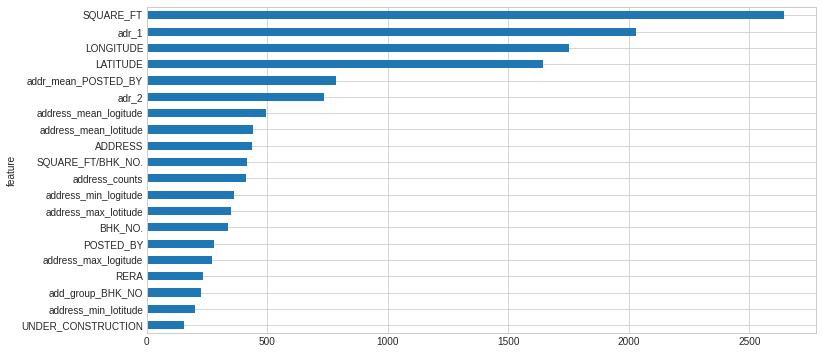

In [ ]:
from sklearn.model_selection import StratifiedKFold
clf = LGBMRegressor(n_estimators = 1000,
                        learning_rate = 0.3,
                        colsample_bytree = 0.7,
                        metric = 'None')

fit_params = {'verbose': 200, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, trn_proc, test_proc, features)

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = lgb_preds_t

In [ ]:
sol_fl

,TARGET(PRICE_IN_LACS)
0,11.748779
1,77.182706
2,66.962653
3,29.291004
4,17.567383
...,...
68715,107.667101
68716,122.275991
68717,5785.497510
68718,83.787301


In [ ]:
sol_fl[sol_fl['TARGET(PRICE_IN_LACS)']<0]

,TARGET(PRICE_IN_LACS)


In [ ]:
sol_fl.to_csv("kFold_lgmb_hyper.csv", index=False)

### Tuning Learning Rate


------------- Fold 1 -------------
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 0.290023
[600]	valid_0's rmse: 0.289816
Early stopping, best iteration is:
[361]	valid_0's rmse: 0.289092

AV metric score for validation set is 0.2890920668487087

------------- Fold 2 -------------
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 0.302513
[600]	valid_0's rmse: 0.302454
Early stopping, best iteration is:
[370]	valid_0's rmse: 0.301219

AV metric score for validation set is 0.30121935648046144

------------- Fold 3 -------------
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 0.30933
[600]	valid_0's rmse: 0.309395
Early stopping, best iteration is:
[395]	valid_0's rmse: 0.30835

AV metric score for validation set is 0.30834969713915206

------------- Fold 4 -------------
Training until validation scores don't improve for 300 rounds.
[300]	valid_0's rmse: 0.294231
[600]	valid_0's

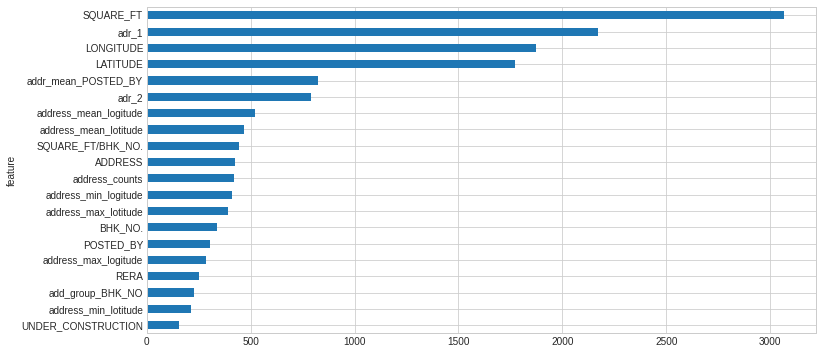

In [ ]:
clf = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.31,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 300, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, trn_proc, test_proc, features)

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = lgb_preds_t

In [ ]:
sol_fl

,TARGET(PRICE_IN_LACS)
0,11.065881
1,74.172308
2,68.132212
3,30.333756
4,16.162731
...,...
68715,107.059727
68716,124.706541
68717,5259.958961
68718,83.283619


In [ ]:
sol_fl.to_csv("kFold_lgmb_learn.csv", index=False)

# CatBoost

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 66.2MB 105kB/s 



------------- Fold 1 -------------
0:	learn: 0.7020670	test: 0.6947814	best: 0.6947814 (0)	total: 8.85ms	remaining: 26.5s
200:	learn: 0.2699814	test: 0.3114544	best: 0.3114544 (200)	total: 1.19s	remaining: 16.6s
400:	learn: 0.2354881	test: 0.2998538	best: 0.2997823 (396)	total: 2.38s	remaining: 15.4s
600:	learn: 0.2152649	test: 0.2955098	best: 0.2955084 (596)	total: 3.56s	remaining: 14.2s
800:	learn: 0.1992440	test: 0.2938520	best: 0.2937230 (747)	total: 4.76s	remaining: 13.1s
1000:	learn: 0.1869653	test: 0.2920956	best: 0.2920507 (996)	total: 5.93s	remaining: 11.8s
1200:	learn: 0.1770286	test: 0.2915909	best: 0.2915134 (1105)	total: 7.11s	remaining: 10.7s
1400:	learn: 0.1696185	test: 0.2916410	best: 0.2911428 (1244)	total: 8.28s	remaining: 9.45s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2911427663
bestIteration = 1244

Shrink model to first 1245 iterations.

AV metric score for validation set is 0.29114276595193983

------------- Fold 2 -------------
0:	lea

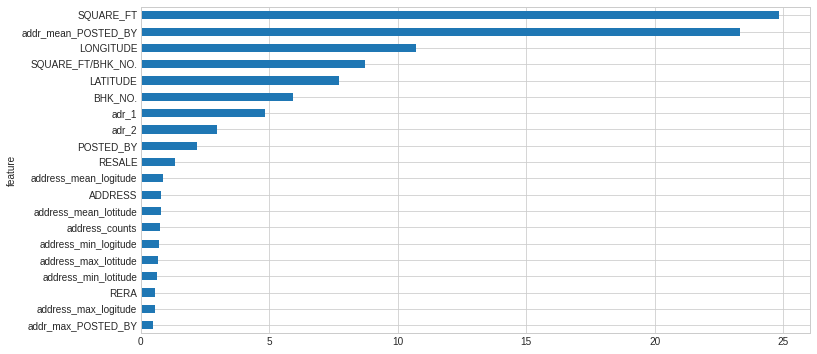

In [ ]:
clf = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.33,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=1,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(clf, fit_params, trn_proc, test_proc, features)

In [ ]:
cb_preds_t = np.expm1(cb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = cb_preds_t

In [ ]:
sol_fl

In [ ]:
sol_fl.to_csv("kFold_cb.csv", index=False)

# XGBoost


------------- Fold 1 -------------
[15:16:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.75005
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.295259
[400]	validation_0-rmse:0.289589
[600]	validation_0-rmse:0.288052
[800]	validation_0-rmse:0.287648
Stopping. Best iteration:
[667]	validation_0-rmse:0.287364


AV metric score for validation set is 0.28736444400914996

------------- Fold 2 -------------
[15:17:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.76079
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.306497
[400]	validation_0-rmse:0.303532
[600]	validation_0-rmse:0.303419
[800]	validation_0-rmse:0.303209
Stopping. Best iteration:
[720]	validation_0-rmse:0.303062


AV metric score for validation set is 

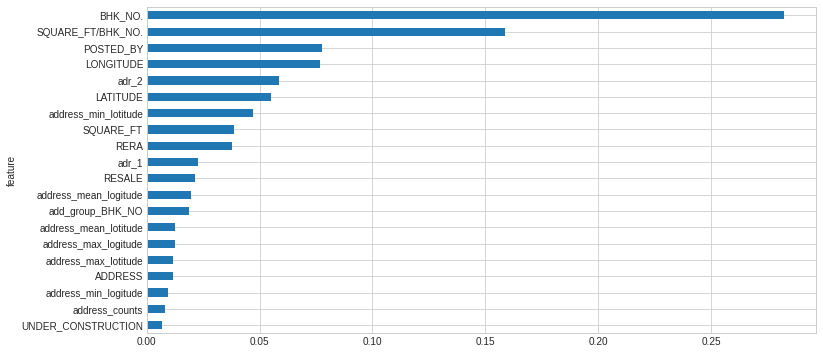

In [ ]:
clf = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.3,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, trn_proc, test_proc, features)

In [ ]:
xg_preds = np.expm1(xgb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = xg_preds

In [ ]:
sol_fl

,TARGET(PRICE_IN_LACS)
0,11.473371
1,72.234839
2,66.618480
3,28.467950
4,13.987209
...,...
68715,106.039462
68716,116.339991
68717,5344.753615
68718,80.224533


In [ ]:
sol_fl.to_csv("kFold_xg.csv", index=False)

# Feature Engineering

In [ ]:
def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  featur = [c for c in df.columns if c not in [TARGET_COL, 'ADDRESS']]
  cols = num_cat_col + num_col + [TARGET_COL]
  df[cols] = df[cols].apply(lambda x: np.log1p(x))

  return df, featur

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [TARGET_COL,'ADDRESS']]
  
  return train, test, features

In [ ]:
df, features = join_df(train, test)

In [ ]:
cat_col

['POSTED_BY', 'BHK_OR_RK']

In [ ]:
df[cat_col] = df[cat_col].apply(lambda x: pd.factorize(x)[0])

In [ ]:
df.head(3)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,0,0.0,0.0,1.098612,0,7.171070,0.693147,0.693147,"Ksfc Layout,Bangalore",2.636906,4.364346,4.025352
1,1,0.0,0.0,1.098612,0,7.151485,0.693147,0.693147,"Vishweshwara Nagar,Mysore",2.585848,4.352142,3.951244
2,0,0.0,0.0,1.098612,0,6.839647,0.693147,0.693147,"Jigani,Bangalore",2.623076,4.364781,3.784190


In [ ]:
features = [c for c in df.columns if c not in [ TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['ADDRESS']]

In [ ]:
cat_num_cols

['POSTED_BY',
 'UNDER_CONSTRUCTION',
 'RERA',
 'BHK_NO.',
 'BHK_OR_RK',
 'SQUARE_FT',
 'READY_TO_MOVE',
 'RESALE',
 'LONGITUDE',
 'LATITUDE']

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
[07:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.65001
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.347213
[400]	validation_0-rmse:0.328996
[600]	validation_0-rmse:0.319305
[800]	validation_0-rmse:0.313943
[999]	validation_0-rmse:0.309792

AV metric score for validation set is 0.3097875932881934

------------- Fold 2 -------------
[07:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.65875
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.355123
[400]	validation_0-rmse:0.338781
[600]	validation_0-rmse:0.329266
[800]	validation_0-rmse:0.323999
[999]	validation_0-rmse:0.320658

AV metric score for validation set is 0.3206573280140601

------------- Fold 3 -------------


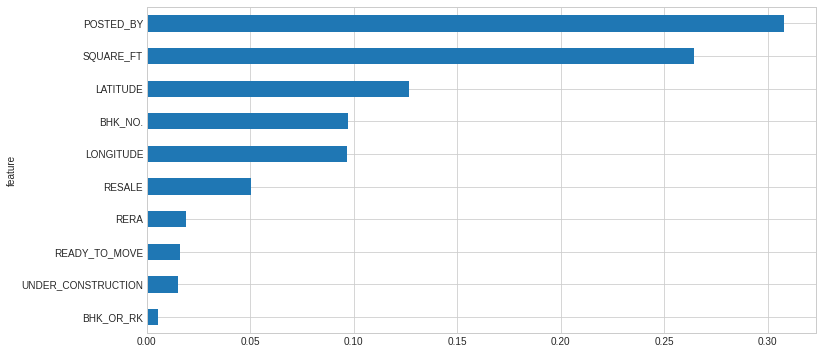

In [ ]:
clf = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452)

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [ ]:
xg_preds = np.expm1(xgb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = xg_preds

In [ ]:
sol_fl.to_csv("feature_xg.csv", index=False)

## Frequency Features

In [ ]:
df['ADDRESS'].nunique()

13322

In [ ]:
df['ADDRESS'].value_counts()

Zirakpur,Chandigarh               1560
Raj Nagar Extension,Ghaziabad      731
Whitefield,Bangalore               677
Sector-137 Noida,Noida             470
New Town,Kolkata                   464
                                  ... 
Flat,Agartala                        1
Godhuli Road,Asansol                 1
Eldeco,Neemrana                      1
Goregoan W ,,Maharashtra             1
Nr.parivar Char Rasta,Vadodara       1
Name: ADDRESS, Length: 13322, dtype: int64

In [ ]:
add_len = []
for c in df['ADDRESS']:
  add_len.append(len(c))

dt = pd.DataFrame()
dt['values'] = add_len

In [ ]:
dt['values'].value_counts()

21    9673
22    8106
19    7890
18    6813
20    6244
      ... 
80       1
81       1
72       1
61       1
67       1
Name: values, Length: 67, dtype: int64

In [ ]:
df['address_counts'] = dt['values'].map(dt['values'].value_counts())
df['address_counts']

0        9673
1        4186
2        6212
3        2934
4        6212
         ... 
98166    8106
98167    5131
98168    6813
98169    3201
98170     575
Name: address_counts, Length: 98171, dtype: int64

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['ADDRESS']]

In [ ]:
cat_num_cols

['POSTED_BY',
 'UNDER_CONSTRUCTION',
 'RERA',
 'BHK_NO.',
 'BHK_OR_RK',
 'SQUARE_FT',
 'READY_TO_MOVE',
 'RESALE',
 'LONGITUDE',
 'LATITUDE',
 'address_counts']


------------- Fold 1 -------------
[13:04:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.65002
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.346963
[400]	validation_0-rmse:0.329676
[600]	validation_0-rmse:0.319474
[800]	validation_0-rmse:0.313698
[999]	validation_0-rmse:0.309139

AV metric score for validation set is 0.3091392640727477

------------- Fold 2 -------------
[13:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.6585
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.353871
[400]	validation_0-rmse:0.336382
[600]	validation_0-rmse:0.325927
[800]	validation_0-rmse:0.320726
[999]	validation_0-rmse:0.317308

AV metric score for validation set is 0.31730839585662274

------------- Fold 3 -------------


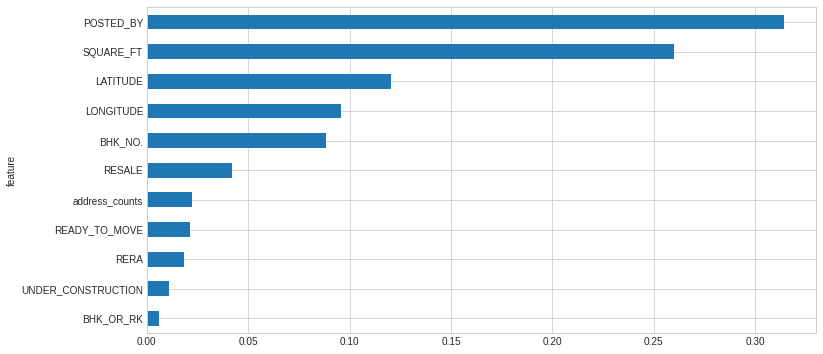

In [ ]:
clf = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452)

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [ ]:
xg_preds = np.expm1(xgb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = xg_preds
sol_fl.to_csv("freq_xg.csv", index=False)

In [ ]:
df['ADDRESS'] = dt['values']

In [ ]:
df['add_group_posted'] = df.groupby('ADDRESS')['POSTED_BY'].transform('nunique')
df['add_group_posted']

0        3
1        3
2        3
3        3
4        3
        ..
98166    3
98167    3
98168    3
98169    3
98170    3
Name: add_group_posted, Length: 98171, dtype: int64

In [ ]:
df['add_group_BHK_NO'] = df.groupby('ADDRESS')['BHK_NO.'].transform('nunique')
df['add_group_BHK_NO']

0         9
1         8
2        12
3         8
4        12
         ..
98166    10
98167     9
98168    13
98169     8
98170     7
Name: add_group_BHK_NO, Length: 98171, dtype: int64

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['ADDRESS']]

In [ ]:
cat_num_cols

['POSTED_BY',
 'UNDER_CONSTRUCTION',
 'RERA',
 'BHK_NO.',
 'BHK_OR_RK',
 'SQUARE_FT',
 'READY_TO_MOVE',
 'RESALE',
 'LONGITUDE',
 'LATITUDE',
 'address_counts',
 'add_group_posted',
 'add_group_BHK_NO']


------------- Fold 1 -------------
[13:06:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.6061
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.311488
[400]	validation_0-rmse:0.30801
[600]	validation_0-rmse:0.305732
[800]	validation_0-rmse:0.307244
Stopping. Best iteration:
[628]	validation_0-rmse:0.305297


AV metric score for validation set is 0.30529758932824574

------------- Fold 2 -------------
[13:06:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.62351
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.325262
[400]	validation_0-rmse:0.31843
[600]	validation_0-rmse:0.317448
[800]	validation_0-rmse:0.316848
Stopping. Best iteration:
[666]	validation_0-rmse:0.316259


AV metric score for validation set is 0.3

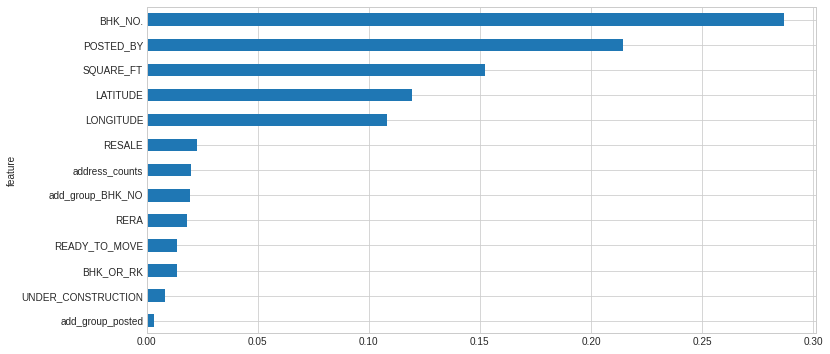

In [ ]:
clf = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.33,
                    colsample_bytree = 0.5,
                    random_state=1452)

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [ ]:
xg_preds = np.expm1(xgb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = xg_preds
sol_fl.to_csv("freq_xg_.csv", index=False)

### Grouping Features

In [ ]:
df['address_mean_logitude'] = df.groupby('ADDRESS')['LONGITUDE'].transform('mean')
df['address_max_logitude'] = df.groupby('ADDRESS')['LONGITUDE'].transform('max')
df['address_min_logitude'] = df.groupby('ADDRESS')['LONGITUDE'].transform('min')

df['address_mean_lotitude'] = df.groupby('ADDRESS')['LATITUDE'].transform('mean')
df['address_max_lotitude'] = df.groupby('ADDRESS')['LATITUDE'].transform('max')
df['address_min_lotitude'] = df.groupby('ADDRESS')['LATITUDE'].transform('min')

In [ ]:
df['SQUARE_FT/BHK_NO.'] = df['SQUARE_FT']//df['BHK_NO.']

In [ ]:
df.shape

(98171, 22)

In [ ]:
new_add = pd.concat([train['ADDRESS'], test['ADDRESS']], axis=0)
adr = new_add.str.split(',', n = 1, expand = True)

In [ ]:
new_add = pd.concat([train['ADDRESS'], test['ADDRESS']], axis=0)
adr = new_add.str.split(',', n = 1, expand = True)
df['adr_1'] = list(adr[0])
df['adr_2'] = list(adr[1])

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['adr_1'] = le.fit_transform(df['adr_1'])
df['adr_2'] = le.fit_transform(df['adr_2'])

In [ ]:
df['addr_mean_POSTED_BY'] = df.groupby('adr_2')['POSTED_BY'].transform('mean')
df['addr_max_POSTED_BY'] = df.groupby('adr_2')['POSTED_BY'].transform('max')
df['addr_min_POSTED_BY'] = df.groupby('adr_2')['POSTED_BY'].transform('min')

In [ ]:
df['addr1_mean_POSTED_BY'] = df.groupby('adr_1')['POSTED_BY'].transform('mean')
df['addr1_max_POSTED_BY'] = df.groupby('adr_1')['POSTED_BY'].transform('max')
df['addr1_min_POSTED_BY'] = df.groupby('adr_1')['POSTED_BY'].transform('min')

In [ ]:
df.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)', 'address_counts',
       'add_group_posted', 'add_group_BHK_NO', 'address_mean_logitude',
       'address_max_logitude', 'address_min_logitude', 'address_mean_lotitude',
       'address_max_lotitude', 'address_min_lotitude', 'SQUARE_FT/BHK_NO.',
       'adr_1', 'adr_2', 'addr_mean_POSTED_BY', 'addr_max_POSTED_BY',
       'addr_min_POSTED_BY', 'addr1_mean_POSTED_BY', 'addr1_max_POSTED_BY',
       'addr1_min_POSTED_BY'],
      dtype='object')

In [ ]:
df['addr1_mean_RERA'] = df.groupby('adr_2')['RERA'].transform('mean')
df['addr1_max_RERA'] = df.groupby('adr_2')['RERA'].transform('max')
df['addr1_min_RERA'] = df.groupby('adr_2')['RERA'].transform('min')

In [ ]:
df['SQUARE_FT_UR'] = df.groupby('SQUARE_FT')['UNDER_CONSTRUCTION'].transform('mean')
df['SQUARE_FT_UR'] = df.groupby('SQUARE_FT')['UNDER_CONSTRUCTION'].transform('max')
df['SQUARE_FT_UR'] = df.groupby('SQUARE_FT')['UNDER_CONSTRUCTION'].transform('min')
df['SQUARE_FT_UR'] = df.groupby('SQUARE_FT')['UNDER_CONSTRUCTION'].transform('sum')

In [ ]:
df['addr_mean_resale'] = df.groupby('adr_2')['RESALE'].transform('mean')

In [ ]:
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ TARGET_COL]]
cat_num_cols = features

In [ ]:
df.head(2)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),address_counts,add_group_posted,add_group_BHK_NO,address_mean_logitude,address_max_logitude,address_min_logitude,address_mean_lotitude,address_max_lotitude,address_min_lotitude,SQUARE_FT/BHK_NO.,adr_1,adr_2,addr_mean_POSTED_BY,addr_max_POSTED_BY,addr_min_POSTED_BY,addr1_mean_POSTED_BY,addr1_max_POSTED_BY,addr1_min_POSTED_BY,addr1_mean_RERA,addr1_max_RERA,addr1_min_RERA,SQUARE_FT_UR,addr_mean_resale
0,0,0.0,0.0,1.098612,0,7.171070,0.693147,0.693147,21,2.636906,4.364346,4.025352,9673,3,9,3.087150,4.089194,2.291047,4.358389,5.034671,-0.030128,6.0,4505,554,0.565379,2,0,0.000000,0,0,0.184379,0.693147,0.0,0.000000,0.666419
1,1,0.0,0.0,1.098612,0,7.151485,0.693147,0.693147,25,2.585848,4.352142,3.951244,4186,3,8,3.083933,3.947726,2.251490,4.345663,5.034671,1.690363,6.0,10293,761,0.513661,2,0,0.722222,1,0,0.087117,0.693147,0.0,2.772589,0.662846


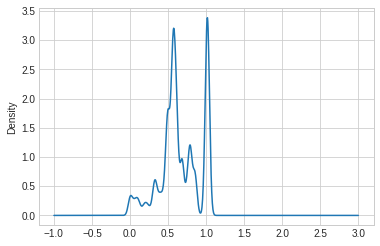


------------- Fold 1 -------------
[08:14:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.5935
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.280353
[400]	validation_0-rmse:0.274893
[600]	validation_0-rmse:0.274147
[800]	validation_0-rmse:0.274117
Stopping. Best iteration:
[630]	validation_0-rmse:0.273501


AV metric score for validation set is 0.2735013435307205

------------- Fold 2 -------------
[08:14:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.6038
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.291745
[400]	validation_0-rmse:0.289165
[600]	validation_0-rmse:0.288908
Stopping. Best iteration:
[429]	validation_0-rmse:0.288641


AV metric score for validation set is 0.2886413177447897

------------- Fo

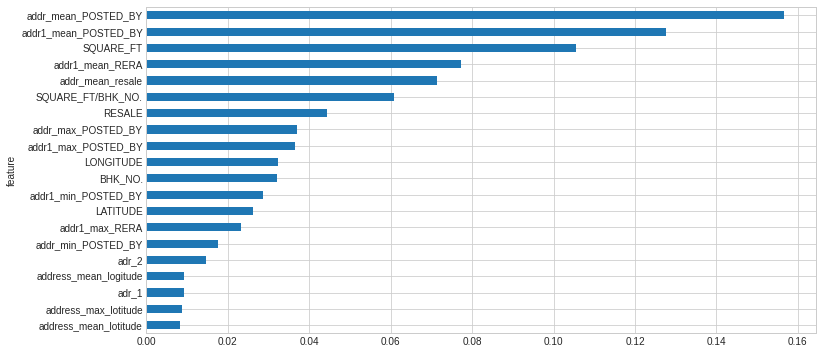

In [ ]:
clf = XGBRegressor(n_estimators = 2000,
                    max_depth = 5,
                    learning_rate = 0.33,
                    colsample_bytree = 0.7,
                    random_state=1)

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

In [ ]:
xg_preds = np.expm1(xgb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = xg_preds
sol_fl.to_csv("group_xg.csv", index=False)


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.291806
[400]	valid_0's rmse: 0.290584
Early stopping, best iteration is:
[367]	valid_0's rmse: 0.290009

AV metric score for validation set is 0.2900093756800576

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.299719
[400]	valid_0's rmse: 0.299598
Early stopping, best iteration is:
[246]	valid_0's rmse: 0.298922

AV metric score for validation set is 0.2989215439443187

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.296963
[400]	valid_0's rmse: 0.296618
Early stopping, best iteration is:
[226]	valid_0's rmse: 0.295913

AV metric score for validation set is 0.2959125957614814

------------- Fold 4 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's rmse: 0.290476
[400]	valid_0's

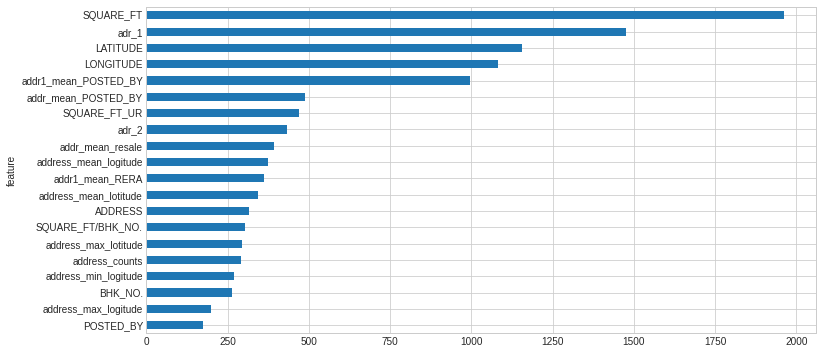

In [ ]:
clf = LGBMRegressor(n_estimators = 2000,
                        learning_rate = 0.33,
                        colsample_bytree = 0.7,
                        metric = 'None',
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)


------------- Fold 1 -------------
0:	learn: 0.7122379	test: 0.6995461	best: 0.6995461 (0)	total: 11.7ms	remaining: 23.4s
200:	learn: 0.2587680	test: 0.3029368	best: 0.3029368 (200)	total: 1.41s	remaining: 12.6s
400:	learn: 0.2234306	test: 0.2932421	best: 0.2931689 (398)	total: 2.81s	remaining: 11.2s
600:	learn: 0.2013485	test: 0.2902499	best: 0.2902499 (600)	total: 4.2s	remaining: 9.77s
800:	learn: 0.1862166	test: 0.2898129	best: 0.2896755 (763)	total: 5.57s	remaining: 8.34s
1000:	learn: 0.1750030	test: 0.2884526	best: 0.2884427 (997)	total: 6.93s	remaining: 6.92s
1200:	learn: 0.1649925	test: 0.2879419	best: 0.2877670 (1178)	total: 8.3s	remaining: 5.52s
1400:	learn: 0.1563843	test: 0.2877482	best: 0.2876770 (1379)	total: 9.68s	remaining: 4.14s
1600:	learn: 0.1486411	test: 0.2876688	best: 0.2875460 (1423)	total: 11s	remaining: 2.75s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.287546033
bestIteration = 1423

Shrink model to first 1424 iterations.

AV metric sco

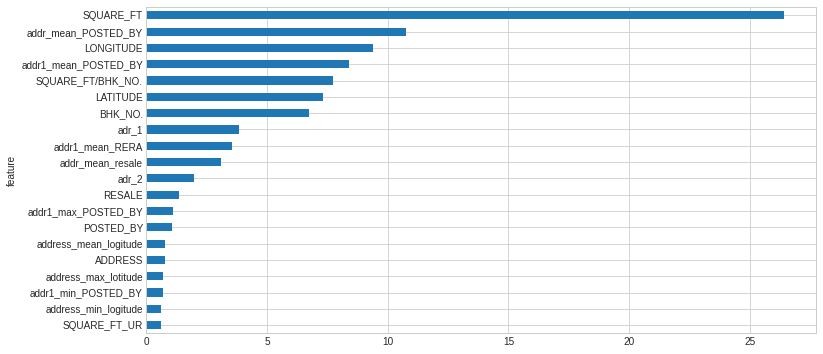

In [ ]:
clf = CatBoostRegressor(n_estimators = 2000,
                       learning_rate = 0.33,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=1)

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_cols)

### Feature Selection

In [ ]:
fi

feature
SQUARE_FT_UR              0.585017
address_min_logitude      0.605154
addr1_min_POSTED_BY       0.675994
address_max_lotitude      0.681833
ADDRESS                   0.750793
address_mean_logitude     0.781945
POSTED_BY                 1.045578
addr1_max_POSTED_BY       1.102351
RESALE                    1.336529
adr_2                     1.981916
addr_mean_resale          3.083256
addr1_mean_RERA           3.527778
adr_1                     3.826246
BHK_NO.                   6.726490
LATITUDE                  7.324611
SQUARE_FT/BHK_NO.         7.723556
addr1_mean_POSTED_BY      8.410380
LONGITUDE                 9.403092
addr_mean_POSTED_BY      10.748650
SQUARE_FT                26.424108
Name: importance, dtype: float64

In [ ]:
to_drop_cols = ['address_max_logitude']

In [ ]:
cat_num_col = [c for c in cat_num_cols if c not in to_drop_cols]


------------- Fold 1 -------------
[07:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.5892
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.28332
[400]	validation_0-rmse:0.278702
[600]	validation_0-rmse:0.278107
Stopping. Best iteration:
[494]	validation_0-rmse:0.277043


AV metric score for validation set is 0.27704289992010994

------------- Fold 2 -------------
[07:32:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.60143
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.292164
[400]	validation_0-rmse:0.28842
Stopping. Best iteration:
[378]	validation_0-rmse:0.287488


AV metric score for validation set is 0.28748763395404725

------------- Fold 3 -------------
[07:33:10] WARNING: /workspace/src/objective/r

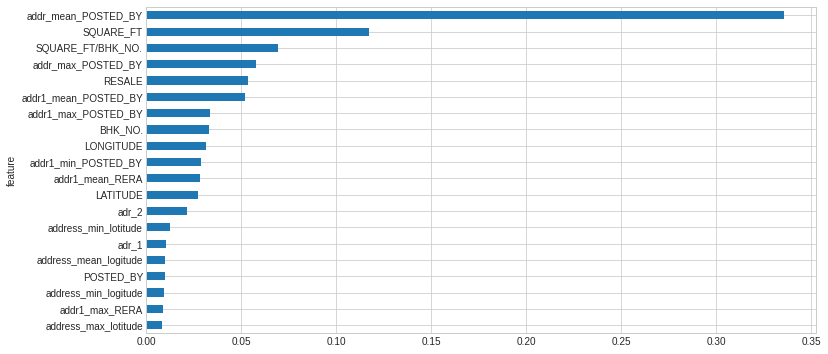

In [ ]:
clf = XGBRegressor(n_estimators = 1000,
                    max_depth = 5,
                    learning_rate = 0.33,
                    colsample_bytree = 0.7,
                    random_state=1)

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(clf, fit_params, train_proc, test_proc, cat_num_col)

In [ ]:
xg_preds = np.expm1(xgb_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = xg_preds
sol_fl.to_csv("group_xg.csv", index=False)

## Ensembling

In [ ]:
av_metrices(np.log1p(train[TARGET_COL]), lgb_oofs*0.20 + cb_oofs*0.20 + xgb_oofs*0.60)

0.281520694504691

In [ ]:
train_new = train[[TARGET_COL]]
train_new[TARGET_COL] = np.log1p(train_new[TARGET_COL])

test_new = pd.DataFrame()

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cb_oofs
test_new['cb'] = cb_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

features = [c for c in train_new.columns if c not in [TARGET_COL]]

In [ ]:
clf = LinearRegression()

ens_oofs, ens_preds = clf_run(clf, train_new, test_new, features)


------------- Fold 1 -------------

AV metric score for validation set is 0.2683504856659577

------------- Fold 2 -------------

AV metric score for validation set is 0.2830773259344496

------------- Fold 3 -------------

AV metric score for validation set is 0.27972972722714934

------------- Fold 4 -------------

AV metric score for validation set is 0.27490722816814334

------------- Fold 5 -------------

AV metric score for validation set is 0.29931518222577574


AV metric for oofs is 0.28126707344641916


In [ ]:
pred = np.expm1(ens_preds)
sol_fl = pd.DataFrame()
sol_fl[TARGET_COL] = pred
sol_fl.to_csv("new_f.csv", index=False)

In [23]:
len(set(zip(test['LONGITUDE'], test['LATITUDE'])))

5962

In [17]:
3189, train=4116, test=5962

4078

In [24]:
k = 0
for c,d in set(zip(test['LONGITUDE'], test['LATITUDE'])):
  if c and d in set(zip(train['LONGITUDE'], train['LATITUDE'])):
    k += 1

SyntaxError: ignored

In [21]:
k

3193

In [4]:
!pip install reverse_geocoder

     |████████████████████████████████| 2.3MB 2.7MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-cp36-none-any.whl size=2268090 sha256=94f09e6dfac2433b04d591f8964844bcae11580983efb09afb9cfccc6df62911
  Stored in directory: /root/.cache/pip/wheels/47/05/50/b1350ff094ef91e082665b4a2f9ca551f8acea4aa55d796b26
Successfully built reverse-geocoder


In [5]:
train.head(2)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0


In [28]:
import reverse_geocoder as rg 
city_name = []
admin1 = []
admin2 = []
cc = []

for idx,idy in set(zip(train['LONGITUDE'], train['LATITUDE'])):
  coordinates =(idx, idy)
  result = (rg.search(coordinates))
  city_name.append(dict(result[0])['name'])
  admin1.append(dict(result[0])['admin1'])
  admin2.append(dict(result[0])['admin2'])
  cc.append(dict(result[0])['cc'])

In [29]:
lat_log_df = pd.DataFrame({'city_name':city_name, 'admin1':admin1, 'admin2':admin2, 'cc':cc})
lat_log_df

,city_name,admin1,admin2,cc
0,Karwar,Karnataka,Uttar Kannada,IN
1,Hubli,Karnataka,Dharwad,IN
2,Valpoy,Goa,North Goa,IN
3,Hubli,Karnataka,Dharwad,IN
4,Ponda,Goa,North Goa,IN
...,...,...,...,...
4111,Akola,Maharashtra,Akola,IN
4112,Vadodara,Gujarat,Vadodara,IN
4113,Aluva,Kerala,Ernakulam,IN
4114,Anjar,Gujarat,Kachchh,IN


In [30]:
lat = []
log = []
for idx,idy in set(zip(train['LONGITUDE'], train['LATITUDE'])):
  lat.append(idy)
  log.append(idx)

In [31]:
lat_log_df['LONGITUDE'] = log
lat_log_df['LATITUDE'] = lat

In [32]:
lat_log_df.to_csv('set_train_city.csv', index=False)

In [ ]:
lat_log_df.nunique()

city_name    962
admin1        69
admin2       388
cc            27
dtype: int64

In [ ]:
coordinates = (train['LONGITUDE'][0], train['LATITUDE'][0]) 
rg.search(coordinates)

[OrderedDict([('lat', '12.97194'),
              ('lon', '77.59369'),
              ('name', 'Bangalore'),
              ('admin1', 'Karnataka'),
              ('admin2', 'Bangalore Urban'),
              ('cc', 'IN')])]

In [ ]:
test.shape

(68720, 11)